<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [46]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [47]:
"""class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y"""

'class Data(Dataset):\n    def __init__(self, dataset):\n        super(Data, self).__init__()\n\n        self.dataset = dataset\n\n    def __len__(self):\n        return len(self.dataset)\n\n    def __getitem__(self, idx):\n        x = self.dataset.data[idx]\n        y = self.dataset.targets[idx]\n        return x, y'

In [48]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)
        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [49]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [50]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

X_train = train_image.data.type(dtype=torch.float32)
y_train = train_image.targets

X_test = test_image.data.type(dtype=torch.float32)
y_test = test_image.targets

# Dequantization
X_train = torch.tensor(X_train).div_(256.) + torch.rand_like(torch.tensor(X_train))
X_train = rescale(X_train, 0., 1.).numpy()

X_test = torch.tensor(X_test).div_(256.) + torch.rand_like(torch.tensor(X_test))
X_test = rescale(X_test, 0., 1.).numpy()

<ipython-input-50-59a6e81ac8e2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).div_(256.) + torch.rand_like(torch.tensor(X_train))
<ipython-input-50-59a6e81ac8e2>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).div_(256.) + torch.rand_like(torch.tensor(X_test))


In [51]:
train_data = Data(X_train)
test_data = Data(X_test)

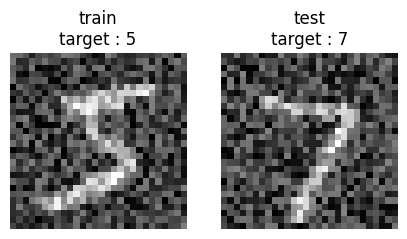

In [52]:
image_train = train_data[0]
category_train = y_train[0]
image_test = test_data[0]
category_test = y_test[0]

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [53]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=16)

train_loader = DataLoader(train_data, batch_size=2000, shuffle=True)


In [54]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%10 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1312.3580444335937
Epoch :  10   -----------> Loss :  -66.65743802388509
Epoch :  20   -----------> Loss :  -295.88404947916666
Epoch :  30   -----------> Loss :  -329.3529571533203
Epoch :  40   -----------> Loss :  -342.0938466389974
Epoch :  50   -----------> Loss :  -351.21510721842446
Epoch :  60   -----------> Loss :  -358.3771901448568
Epoch :  70   -----------> Loss :  -364.51902669270834
Epoch :  80   -----------> Loss :  -369.510215250651
Epoch :  90   -----------> Loss :  -373.8269897460938
Epoch :  100   -----------> Loss :  -377.4122772216797


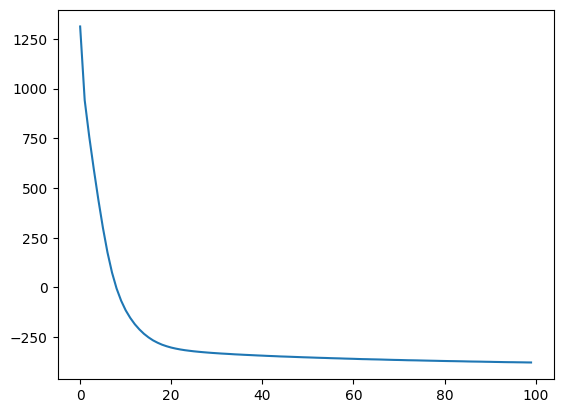

In [55]:
plt.plot(COST)

In [56]:
test = prior.sample((50,))
test

tensor([[ 0.9639,  0.5565, -0.0930,  ..., -0.1691, -0.1071,  1.1871],
        [-2.3667,  0.3723,  0.0337,  ...,  0.1873,  0.2941,  0.6528],
        [-1.4533, -0.8840,  1.9239,  ...,  0.2160, -0.4988, -0.7519],
        ...,
        [ 0.0733, -0.2526, -1.2249,  ..., -0.4897, -2.0144,  0.8323],
        [ 1.6542,  0.7676,  1.2714,  ..., -1.9294,  0.3048,  0.5294],
        [-1.1435, -1.6853,  1.2363,  ..., -0.4187,  0.6411,  0.4044]])

In [57]:
sonuc = model.f_inv(test)
sonuc

tensor([[0.3824, 0.3583, 0.0978,  ..., 0.2872, 0.2960, 0.5397],
        [0.3069, 0.2488, 0.0338,  ..., 0.1803, 0.0356, 0.1663],
        [0.4617, 0.1533, 0.3470,  ..., 0.5232, 0.2155, 0.0294],
        ...,
        [0.0480, 0.0911, 0.4380,  ..., 0.2846, 0.3841, 0.2761],
        [0.1499, 0.4167, 0.2267,  ..., 0.1507, 0.3349, 0.1498],
        [0.2855, 0.4802, 0.2989,  ..., 0.2929, 0.1479, 0.3372]],
       grad_fn=<MulBackward0>)

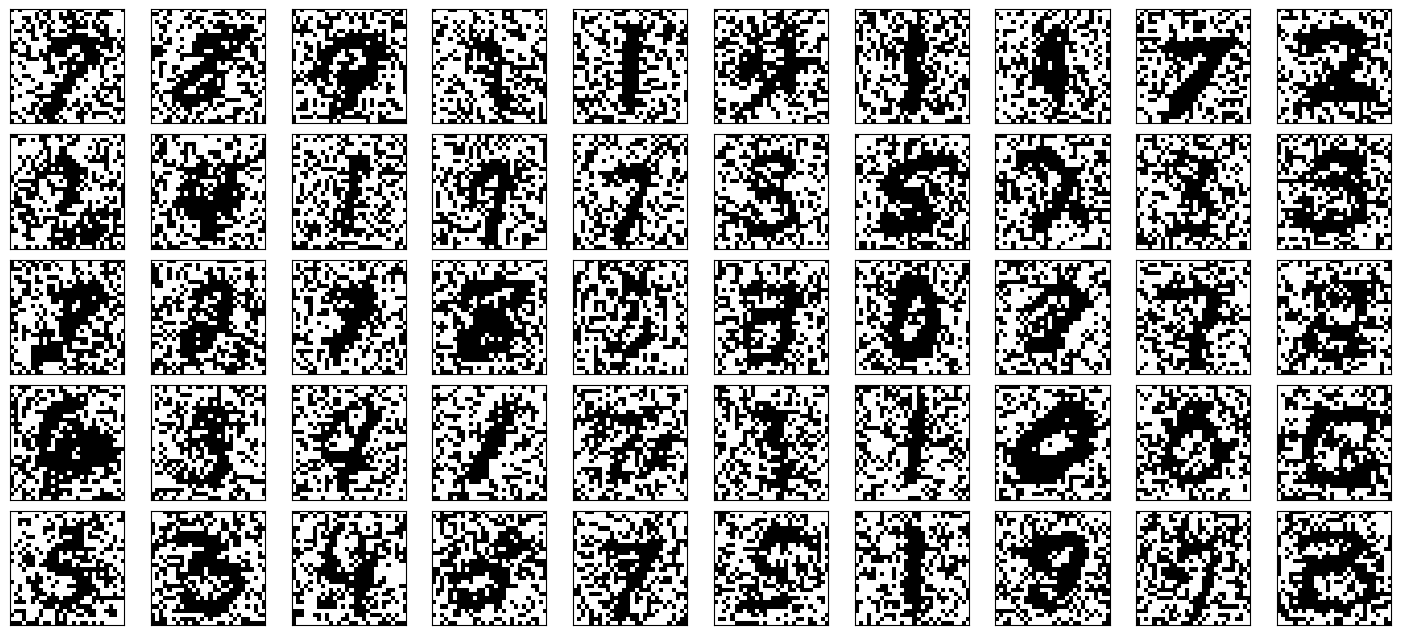

In [102]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.3] = 1
sonuc[sonuc[:]<=0.3] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

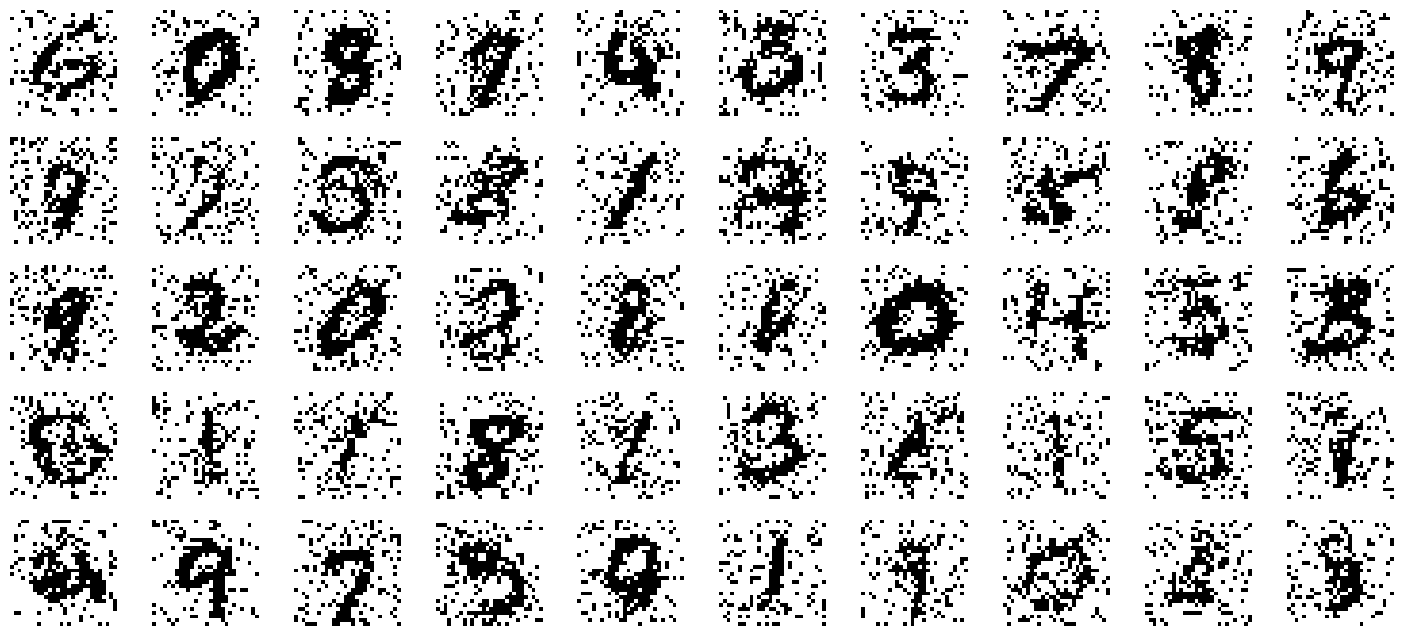

In [103]:
test = prior.sample((50,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.4] = 1
sonuc[sonuc[:]<=0.4] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    axs[3, i].axis('off')
    axs[4, i].axis('off')
fig.show()

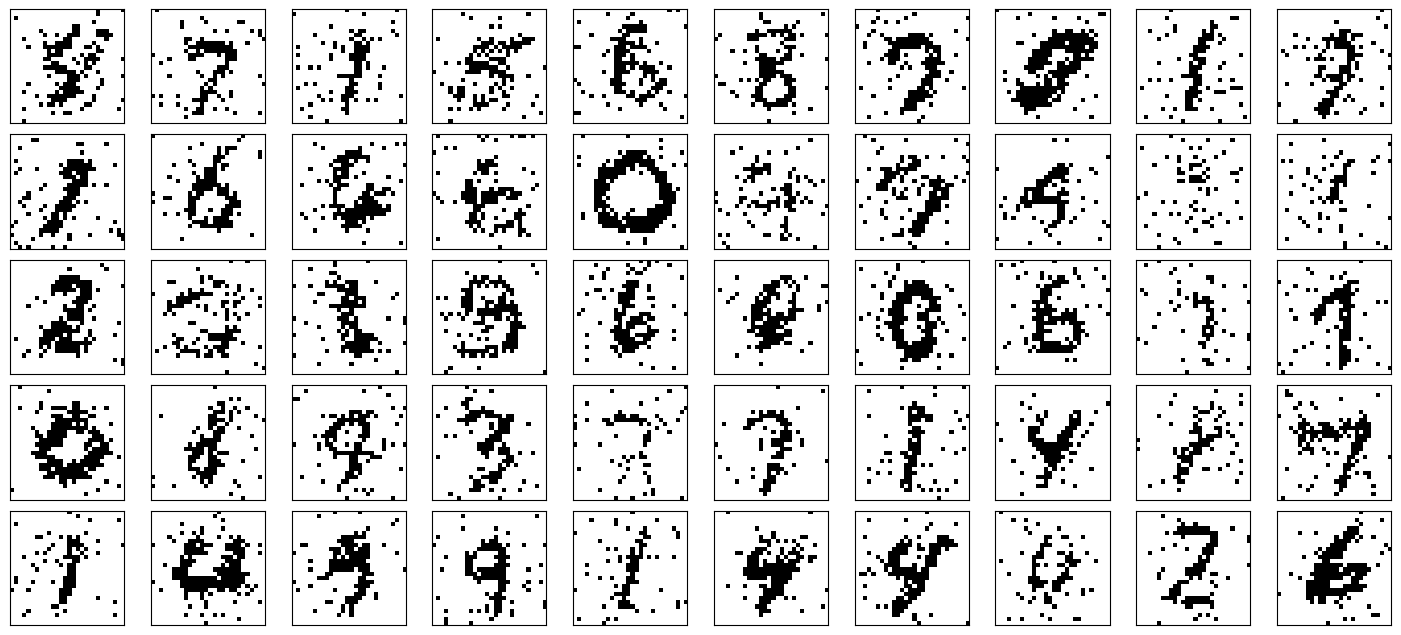

In [104]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)

sonuc[sonuc[:]>0.5] = 1
sonuc[sonuc[:]<=0.5] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

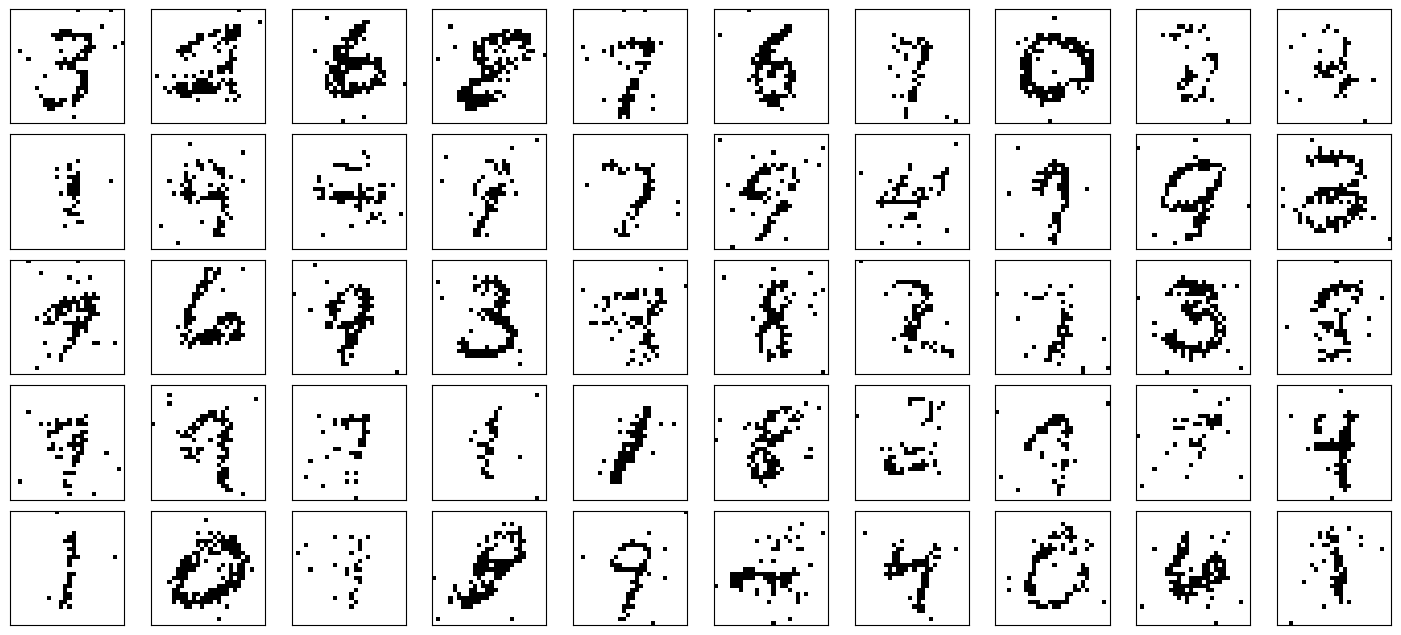

In [105]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.6] = 1
sonuc[sonuc[:]<=0.6] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

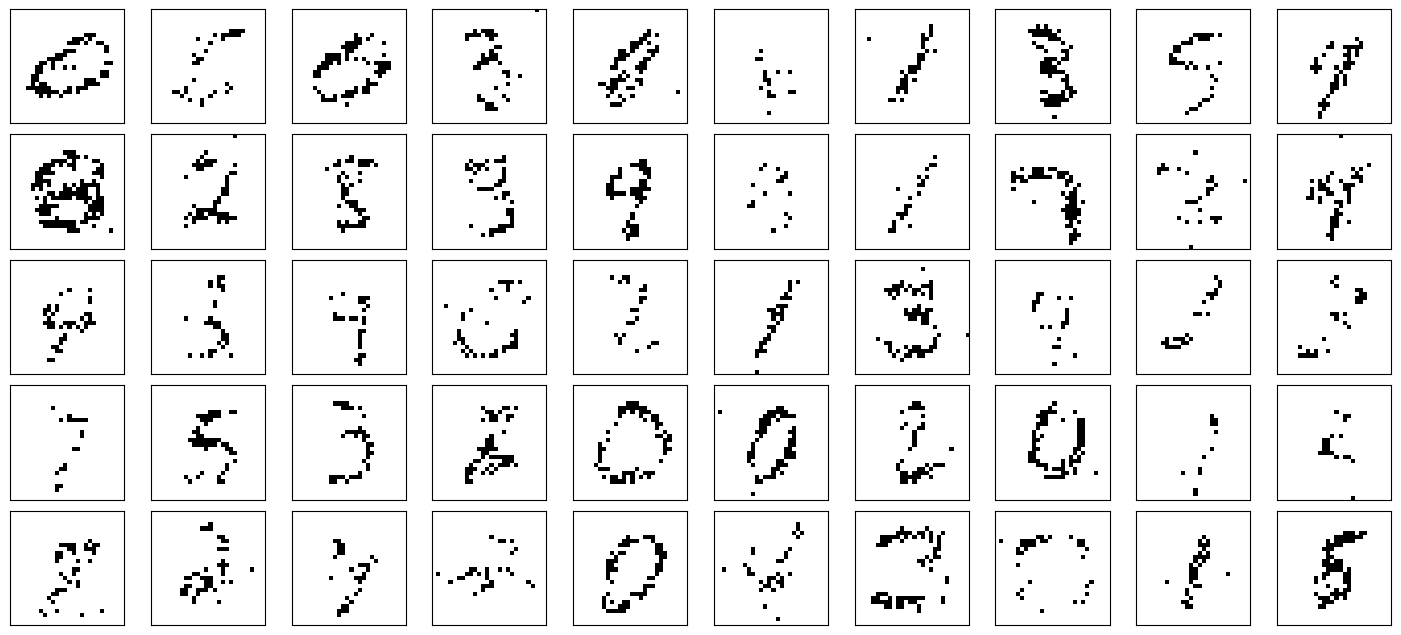

In [106]:
test = prior.sample((1797,))
sonuc = (model.f_inv(test))
sonuc[sonuc[:]>0.7] = 1
sonuc[sonuc[:]<=0.7] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

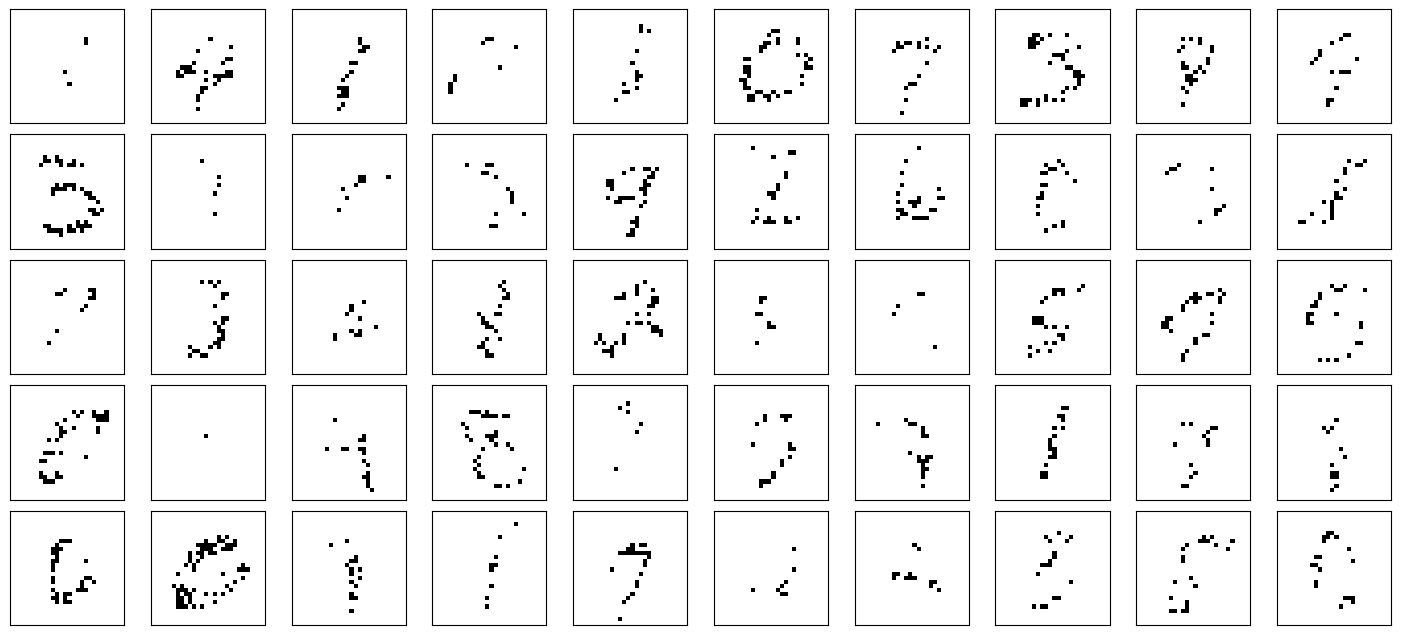

In [107]:
test = prior.sample((1797,))
sonuc = (model.f_inv(test))
sonuc[sonuc[:]>0.8] = 1
sonuc[sonuc[:]<=0.8] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()